In [1]:
!pip install albumentations


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import time
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchvision.utils import make_grid

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

C:\Users\pcs\AppData\Local\Temp\ipykernel_6800\1057763112.py:21: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [3]:
import glob

# Use raw string to handle backslashes in Windows paths
mask_paths = glob.glob(r"C:\\Users\\pcs\\OneDrive\\Desktop\\Project Major\\kaggle_3m\\*\\*_mask*")

# Optional: Preview the first few mask paths
print(f"Found {len(mask_paths)} mask files.")
mask_paths[:5]


Found 3929 mask files.


['C:\\\\Users\\\\pcs\\\\OneDrive\\\\Desktop\\\\Project Major\\\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif',
 'C:\\\\Users\\\\pcs\\\\OneDrive\\\\Desktop\\\\Project Major\\\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif',
 'C:\\\\Users\\\\pcs\\\\OneDrive\\\\Desktop\\\\Project Major\\\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif',
 'C:\\\\Users\\\\pcs\\\\OneDrive\\\\Desktop\\\\Project Major\\\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13_mask.tif',
 'C:\\\\Users\\\\pcs\\\\OneDrive\\\\Desktop\\\\Project Major\\\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14_mask.tif']

In [4]:
csv_path = r"C:\\Users\\pcs\\OneDrive\\Desktop\\Project Major\\kaggle_3m\\data.csv"

# Read the CSV file
df = pd.read_csv(csv_path)

# Count and display missing values in each column
missing_values_count = df.isnull().sum()
print("Missing values per column:\n", missing_values_count)

Missing values per column:
 Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64


In [5]:
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0


In [6]:
def get_file_row(path):
    """
    Extracts patient ID, image path, and corresponding mask path from a given image file path.

    Parameters:
    path (str): The full path to the image file (not the mask).

    Returns:
    list: [patient_id, image_path, mask_path]
    """
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    patient_id = '_'.join(filename.split('_')[:3])  # Patient ID is the first 3 parts of the filename
    mask_path = f"{path_no_ext}_mask{ext}"
    return [patient_id, path, mask_path]


In [7]:
import glob

image_paths = glob.glob(r"C:\\Users\\pcs\\OneDrive\\Desktop\\Project Major\\kaggle_3m\\*\*.tif")
image_paths = [p for p in image_paths if '_mask' not in p]

# Then use it to build the DataFrame
PathDF = pd.DataFrame((get_file_row(filename) for filename in image_paths), columns=['Patient', 'image', 'mask'])
PathDF.head()


,Patient,image,mask
0,TCGA_CS_4941,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...
1,TCGA_CS_4941,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...
2,TCGA_CS_4941,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...
3,TCGA_CS_4941,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...
4,TCGA_CS_4941,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...,C:\\Users\\pcs\\OneDrive\\Desktop\\Project Maj...


In [8]:
class MRI_Dataset(Dataset):
    def __init__(self, df, transform=None):
        super(MRI_Dataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)

        if raw:
            return img, mask

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = transforms.functional.to_tensor(img)  # Converts HWC numpy to CHW tensor
        mask = torch.tensor(mask, dtype=torch.float32) / 255.0  # Normalize to 0/1 float mask

        return img, mask


In [9]:
from sklearn.model_selection import train_test_split

train_df, rest = train_test_split(PathDF, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(rest, test_size=0.3, random_state=42)

print(f"Train: {train_df.shape[0]} | Validation: {valid_df.shape[0]} | Test: {test_df.shape[0]}")


Train: 2750 | Validation: 354 | Test: 825


In [10]:
transform = albumentations.Compose([
    albumentations.ChannelDropout(p=0.3),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.ColorJitter(p=0.3),
])

train_dataset = MRI_Dataset(train_df, transform)
valid_dataset = MRI_Dataset(valid_df)
test_dataset = MRI_Dataset(test_df)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

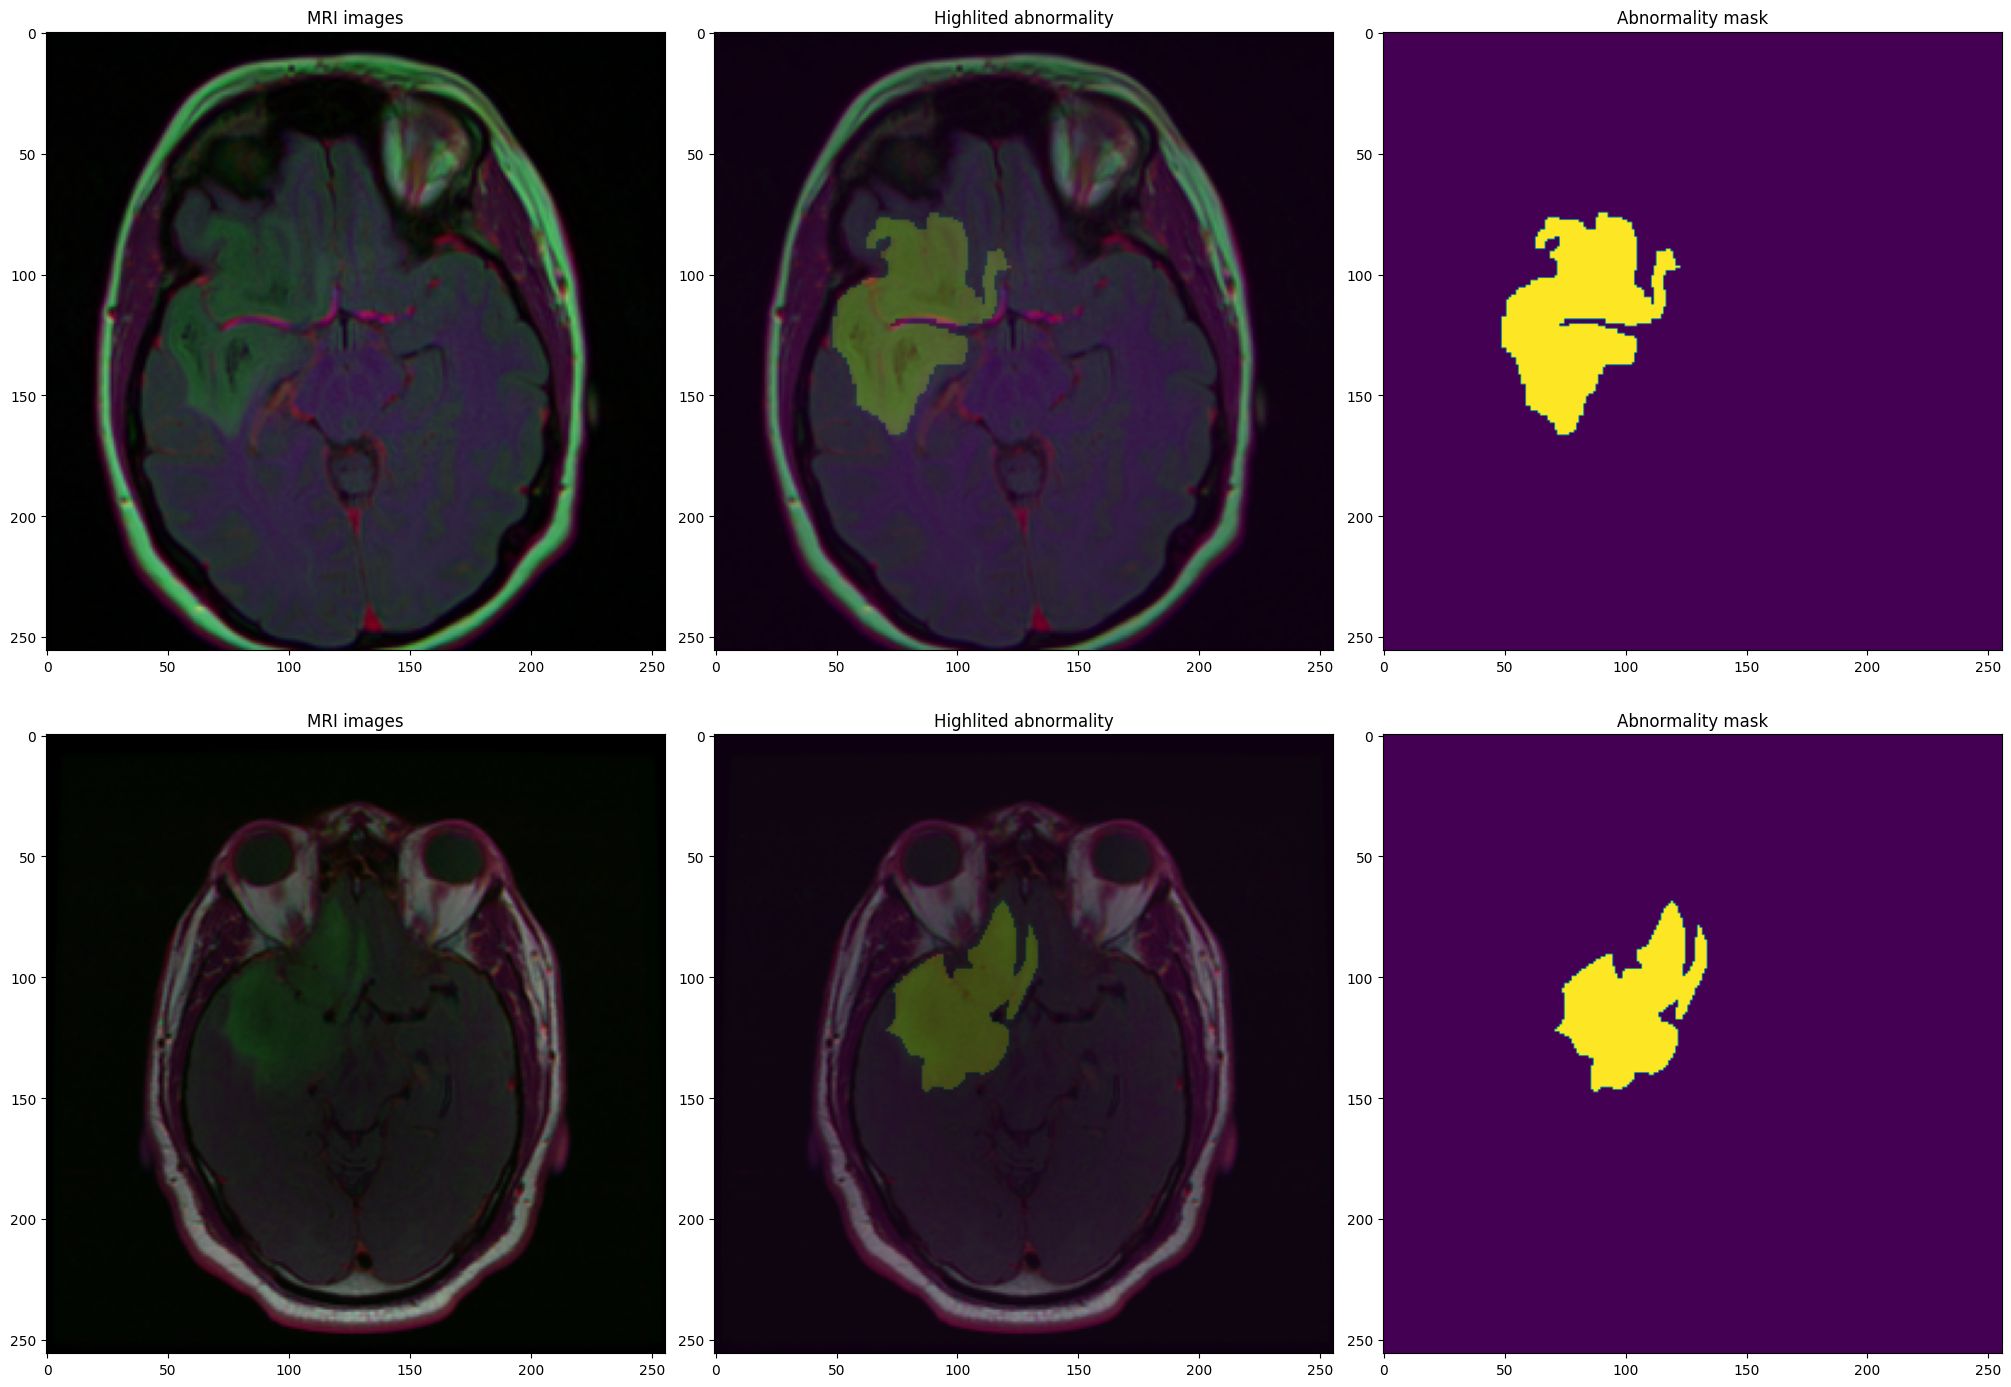

In [11]:
%matplotlib inline
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

In [12]:
class double_convolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_convolution, self).__init__()
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
        return x

In [13]:
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        return x

In [14]:
class downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(downsample_block, self).__init__()
        self.Downconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            double_convolution(in_channels, out_channels)
         )
    def forward(self, x):
        x = self.Downconv(x)
        return x

In [15]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_convolution(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [16]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64)
        self.down1 = downsample_block(64, 128)
        self.down2 = downsample_block(128, 256)
        self.down3 = downsample_block(256, 512)
        self.down4 = downsample_block(512, 512)
        self.up1 = upsample_block(1024, 256)
        self.up2 = upsample_block(512, 128)
        self.up3 = upsample_block(256, 64)
        self.up4 = upsample_block(128, 64)
        self.outc = OutConv(64, num_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.to(device);

In [19]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 25

In [20]:
def segmentation_accuracy(preds, targets, threshold=0.5): 
    # Apply sigmoid and threshold to get binary predictions
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    acc = correct.sum() / correct.numel()
    return acc   

In [21]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        running_acc = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            
            loss = loss_fn(predictions, mask)
            acc = segmentation_accuracy(predictions, mask)
            
            running_loss += loss.item() * img.size(0)
            running_acc += acc.item() * img.size(0)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        running_valid_loss = 0
        running_valid_acc = 0
        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                
                loss = loss_fn(predictions, mask)
                acc = segmentation_accuracy(predictions, mask)

                running_valid_loss += loss.item() * img.size(0)
                running_valid_acc += acc.item() * img.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        train_acc = running_acc / len(train_loader.dataset)
        val_acc = running_valid_acc / len(valid_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)sssssssss

        print(f'Epoch: {epoch}/{epochs} | '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
    
    model.eval()
    return history


In [22]:
history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn)      

100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [45:56<00:00, 16.02s/it]


Epoch: 1/25 | Train Loss: 0.1626, Acc: 0.0106 | Val Loss: 0.0594, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:31<00:00, 15.53s/it]


Epoch: 2/25 | Train Loss: 0.0496, Acc: 0.0106 | Val Loss: 0.0309, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:22<00:00, 15.48s/it]


Epoch: 3/25 | Train Loss: 0.0385, Acc: 0.0106 | Val Loss: 0.0307, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:24<00:00, 15.49s/it]


Epoch: 4/25 | Train Loss: 0.0354, Acc: 0.0106 | Val Loss: 0.0215, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:38<00:00, 15.58s/it]


Epoch: 5/25 | Train Loss: 0.0305, Acc: 0.0106 | Val Loss: 0.0222, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:25<00:00, 15.50s/it]


Epoch: 6/25 | Train Loss: 0.0295, Acc: 0.0106 | Val Loss: 0.0187, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:24<00:00, 15.49s/it]


Epoch: 7/25 | Train Loss: 0.0291, Acc: 0.0106 | Val Loss: 0.0191, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:26<00:00, 15.50s/it]


Epoch: 8/25 | Train Loss: 0.0284, Acc: 0.0106 | Val Loss: 0.0217, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:27<00:00, 15.51s/it]


Epoch: 9/25 | Train Loss: 0.0255, Acc: 0.0106 | Val Loss: 0.0186, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:19<00:00, 15.46s/it]


Epoch: 10/25 | Train Loss: 0.0252, Acc: 0.0106 | Val Loss: 0.0170, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:58<00:00, 15.69s/it]


Epoch: 11/25 | Train Loss: 0.0246, Acc: 0.0106 | Val Loss: 0.0174, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:55<00:00, 15.67s/it]


Epoch: 12/25 | Train Loss: 0.0240, Acc: 0.0106 | Val Loss: 0.0139, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [45:02<00:00, 15.71s/it]


Epoch: 13/25 | Train Loss: 0.0238, Acc: 0.0106 | Val Loss: 0.0143, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:31<00:00, 15.53s/it]


Epoch: 14/25 | Train Loss: 0.0237, Acc: 0.0106 | Val Loss: 0.0165, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:17<00:00, 15.45s/it]


Epoch: 15/25 | Train Loss: 0.0219, Acc: 0.0106 | Val Loss: 0.0196, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:58<00:00, 15.69s/it]


Epoch: 16/25 | Train Loss: 0.0210, Acc: 0.0106 | Val Loss: 0.0150, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [45:00<00:00, 15.70s/it]


Epoch: 17/25 | Train Loss: 0.0205, Acc: 0.0106 | Val Loss: 0.0140, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:54<00:00, 15.66s/it]


Epoch: 18/25 | Train Loss: 0.0201, Acc: 0.0106 | Val Loss: 0.0144, Acc: 0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:08<00:00, 15.40s/it]


Epoch: 19/25 | Train Loss: 0.0199, Acc: 0.0106 | Val Loss: 0.0121, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:07<00:00, 15.39s/it]


Epoch: 20/25 | Train Loss: 0.0188, Acc: 0.0106 | Val Loss: 0.0149, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:05<00:00, 15.38s/it]


Epoch: 21/25 | Train Loss: 0.0184, Acc: 0.0107 | Val Loss: 0.0156, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:25<00:00, 15.50s/it]


Epoch: 22/25 | Train Loss: 0.0177, Acc: 0.0107 | Val Loss: 0.0121, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:52<00:00, 15.65s/it]


Epoch: 23/25 | Train Loss: 0.0176, Acc: 0.0107 | Val Loss: 0.0114, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:03<00:00, 15.37s/it]


Epoch: 24/25 | Train Loss: 0.0168, Acc: 0.0106 | Val Loss: 0.0102, Acc: 0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [44:26<00:00, 15.50s/it]


Epoch: 25/25 | Train Loss: 0.0164, Acc: 0.0107 | Val Loss: 0.0110, Acc: 0.0096


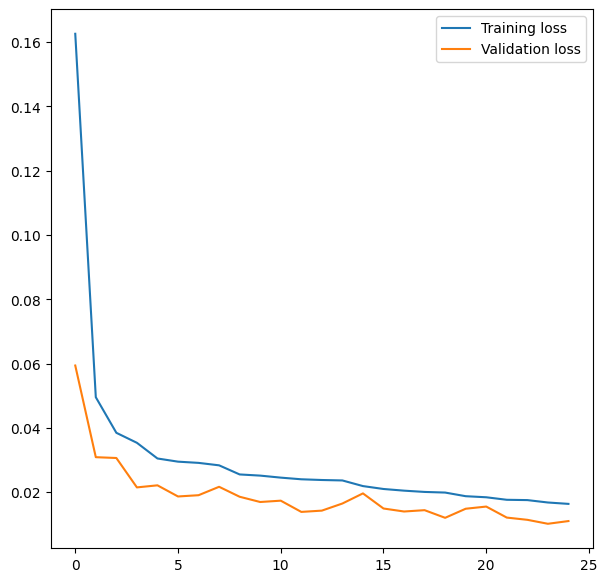

In [23]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [24]:
with torch.no_grad():
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        predictions = predictions.squeeze(1)
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)
    
    print(f'Tests: loss: {loss}')

Tests: loss: 0.012841385192567197


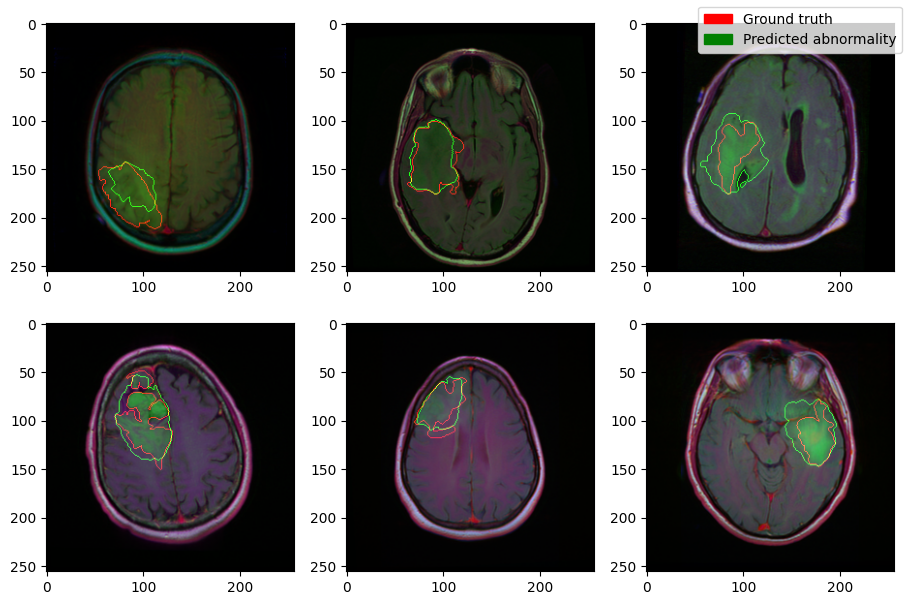

In [25]:
%matplotlib inline

width = 3
columns = 2
n_examples = 6

fig, axs = plt.subplots(columns, width, figsize=(3*width , 3*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1